In [1]:
import os
from PIL import Image
import torch

from diffusion.controlnet import ControlNetModel
from diffusion.pipeline_controlnet import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
from diffusers.utils import load_image

device = "cuda:0"

c:\Users\subham\.conda\envs\controlnet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set model paths

In [2]:
base_model_path = "runwayml/stable-diffusion-v1-5"      # NOTE: set as the base Stable Diffusion model
controlnet_path = "./runs/controlnet_fill50k"           # NOTE: set as the output directory of your ControlNet training

### Load models and scheduler

In [3]:
# Load ControlNet
controlnet = ControlNetModel.from_pretrained(
    controlnet_path, 
    torch_dtype=torch.float16
)
# Load Stable Diffusion with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, 
    controlnet=controlnet, 
    torch_dtype=torch.float16,
    safety_checker=None,
)
# Set scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Load model to GPU
pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\subham\.conda\envs\controlnet\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
You have disabled the safety checker for <class 'diffusion.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling 

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.28.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusion.controlnet",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Load condition for ControlNet

Prompt: pale golden rod circle with old lace background


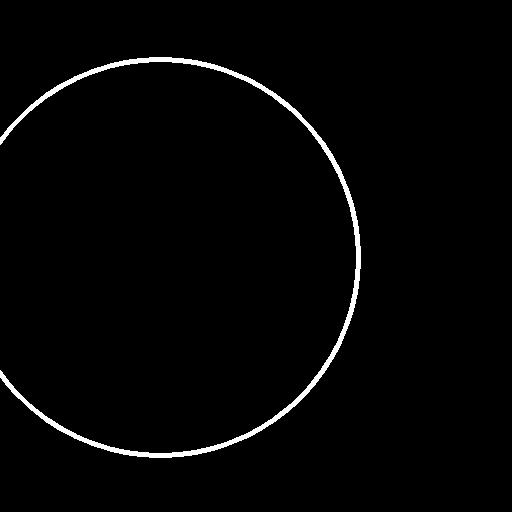

In [4]:
control_image = load_image("./data/conditioning_image_1.png")
prompt = "pale golden rod circle with old lace background"

print(f"Prompt: {prompt}")
control_image

100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


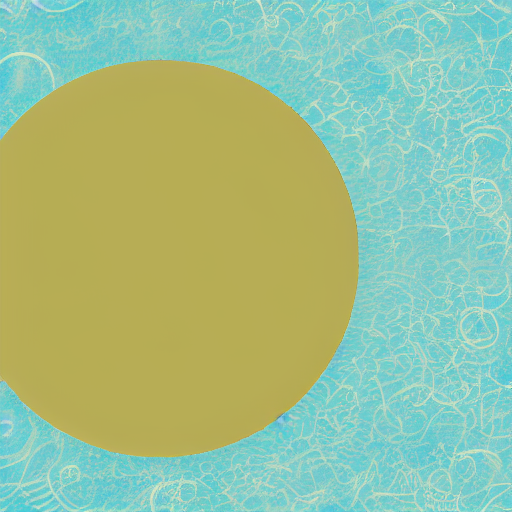

In [5]:
seed = 10
generator = torch.manual_seed(seed)

# Generate image
image = pipe(
    prompt, 
    num_inference_steps=20, 
    generator=generator, 
    image=control_image
).images[0]

image
# image.save("./output.png")

In [ ]:
import json
from diffusers.utils import load_image

prompts = json.load(open("data/test_prompts.json"))
for i, prompt in prompts.items():
    cond = load_image(f"data/test_conditions/conditioning_image_{i}.png")
    out = pipe(prompt, image=cond, num_inference_steps=50, generator=torch.manual_seed(0)).images[0]
    out.save(f"controlnet_out_{i}.png")


In [8]:
import json
import torch
from diffusers import StableDiffusionPipeline

# Load the correct standard Stable Diffusion model
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

# Load prompts
with open("./data/test_prompts.json", 'r') as f:
    prompts = json.load(f)

# Generate images
for i, prompt in prompts.items():
    print(f"Generating image for prompt: {prompt}")
    image = pipe(prompt).images[0]
    image.save(f"original_sd_image_{i}.png")


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Generating image for prompt: pale golden rod circle with old lace background


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


Generating image for prompt: sea green circle with a light cyan background


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


Generating image for prompt: deep sky blue circle with a light yellow background


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


Generating image for prompt: rosy brown circle with a misty rose background


100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


Generating image for prompt: forest green circle with an antique brown background


100%|██████████| 50/50 [00:03<00:00, 16.50it/s]


In [10]:

# Load prompts
with open("./data/test_prompts.json", "r") as f:
    prompts = json.load(f)

output_dir = "with_controlnet"
os.makedirs(output_dir, exist_ok=True)


# Utility function to load image with extension check
def load_condition_image(index):
    base_path = f"./data/test_conditions/{index}"
    for ext in [".png", ".jpg", ".jpeg"]:
        path = base_path + ext
        if os.path.exists(path):
            return load_image(path)
    raise FileNotFoundError(f"No image found for {index} with supported extensions.")

# Run inference for each prompt + condition image pair
for i, prompt in prompts.items():
    print(f"Generating for prompt {i}: {prompt}")

    # Load corresponding condition image (auto-handles .png/.jpg)
    control_image = load_condition_image(i)

    # Generate image
    generator = torch.manual_seed(10)
    image = pipe(
        prompt=prompt,
        image=control_image,
        num_inference_steps=50,
        generator=generator
    ).images[0]

    # Save output
    out_path = os.path.join(output_dir, f"controlnet_out_{i}.png")
    image.save(out_path)
    print(f"Saved: {out_path}")

Generating for prompt 0: pale golden rod circle with old lace background


100%|██████████| 50/50 [00:03<00:00, 13.39it/s]


Saved: with_controlnet\controlnet_out_0.png
Generating for prompt 1: sea green circle with a light cyan background


100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


Saved: with_controlnet\controlnet_out_1.png
Generating for prompt 2: deep sky blue circle with a light yellow background


100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


Saved: with_controlnet\controlnet_out_2.png
Generating for prompt 3: rosy brown circle with a misty rose background


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


Saved: with_controlnet\controlnet_out_3.png
Generating for prompt 4: forest green circle with an antique brown background


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


Saved: with_controlnet\controlnet_out_4.png
